In [1]:
%matplotlib inline
# %load ../../utility/initialization.py
'''
How to Train Your Dragon: V4
Sequentially initialize FT reactive distillation model automatically
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-04 02:40:42 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=1e-5,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)
        
for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
    return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
            sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
check_DOF(pe,model)

Active Equality Constraints:	 29862
Active Inequality Constraints:	 21
Active Variables:		 33597
Fixed Variables:		 3662
DOF:				 73


In [16]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
    

In [18]:
# pdf = PdfPages(log_figure_dir)

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

# plot_distribution(model,pdf,'Original 20 stage case')


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

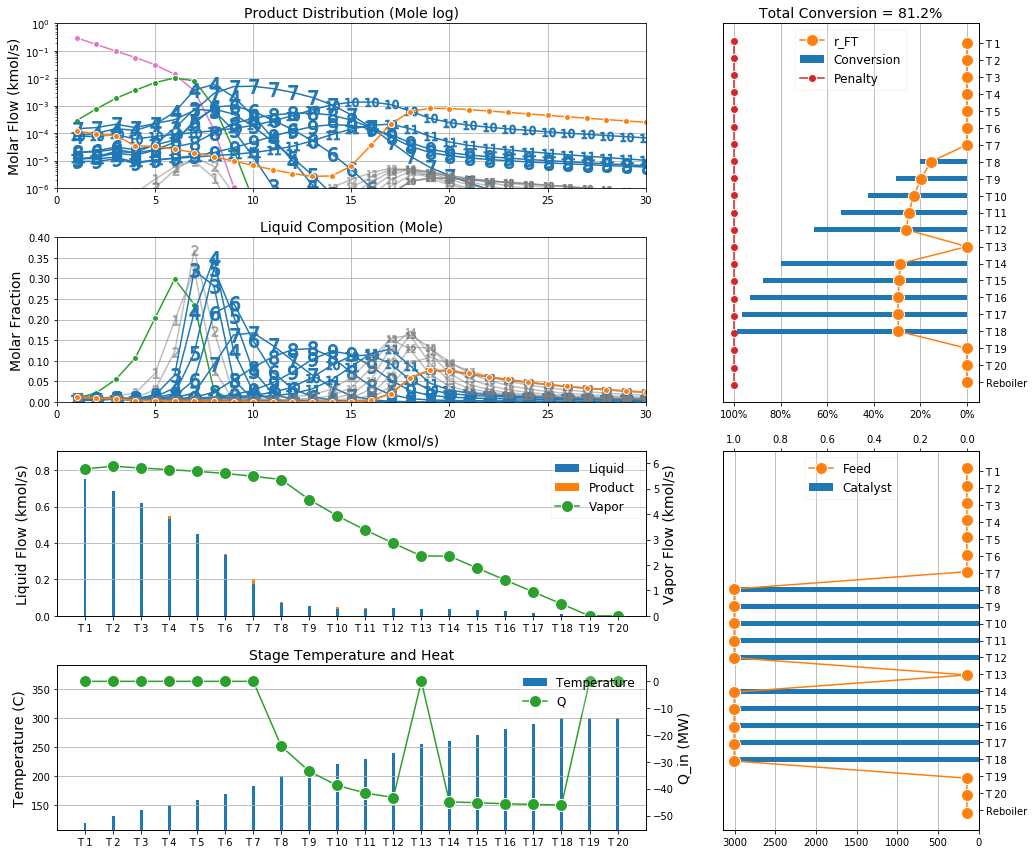

In [20]:
plot_distribution(model)

# Optimization Input

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw ratio
    * PR_L: 0 - 1

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

### Open up parameters

In [21]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

In [22]:
model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [23]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

In [24]:
def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [25]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [26]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
    

  66 -1.0226021e-01 2.07e+00 5.76e+01  -6.0 2.39e+03    -  1.00e+00 6.00e-02h  2
  67 -1.0226970e-01 1.93e+00 4.40e+01  -6.0 7.74e+02    -  2.83e-01 1.86e-01h  1
  68 -1.0227152e-01 9.28e-04 4.95e+01  -6.0 7.05e+00    -  2.47e-01 1.00e+00h  1
  69 -1.0227116e-01 2.14e-04 5.79e-04  -6.0 4.31e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0227096e-01 1.04e-04 2.47e-05  -6.0 3.00e+00    -  1.00e+00 1.00e+00h  1
  71 -1.0227096e-01 6.29e-10 1.69e-10  -6.0 7.22e-03    -  1.00e+00 1.00e+00h  1
  72 -1.0240519e-01 1.28e+00 5.24e+01  -9.0 2.07e+02    -  8.66e-01 9.04e-01f  1
  73 -1.0238866e-01 7.73e-01 3.27e+01  -9.0 3.75e+01    -  8.97e-01 3.60e-01h  1
  74 -1.0235869e-01 2.50e-02 4.00e-01  -9.0 2.35e+01    -  1.00e+00 9.85e-01h  1
  75 -1.0235758e-01 1.05e-04 1.74e-04  -9.0 9.56e-01    -  1.00e+00 1.00e+00h  1
  76 -1.0235758e-01 3.12e-10 9.07e-11  -9.0 2.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

In [27]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

# plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Side Draw')


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.03%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1386          0.9921  0.0871       2.3285

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5466  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7857  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7303  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

In [28]:
# tray_num = len(model.TRAY_total)
# tray_pos = np.arange(tray_num)

# naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
# gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
# diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
# heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

# fig, ax = plt.subplots(figsize=(16,9))
# ax.bar(tray_pos,naphtha_flow,alpha=0.7)
# ax.bar(tray_pos,gasoline_flow,alpha=0.7)
# ax.bar(tray_pos,diesel_flow,alpha=0.7)
# ax.bar(tray_pos,heavy_flow,alpha=0.7)

# ax.legend(['naphtha','gasoline','diesel','heavy'])
# ax.set_title('DDF Product Distribution')
# ax.set_ylabel('Flow kmol/s')
# ax.set_xlabel('Tray Number')

# ax.grid()
# plt.show()

# Use DDF,  open up gasoline location

In [29]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [30]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
    

In [31]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

# plot_distribution(model,pdf,'Optimized Gasoline Location')


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 87.50%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -151.                                        2.1363          0.7792  0.0812       2.3197

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     127.5  0.000       0.000  0.000  0.000  0.000       5.3165  0.0000  0.9217  0.0000       20.000
NON--[2]     141.2  0.000       0.000  0.000  0.000  0.000       5.4590  0.0000  0.8360  0.0000       20.000
NON--[3]     152.9  0.000       0.000  0.000  0.000  0.000       5.3734  0.0000  0.7452  0.0000       20.000
NON--[4]     165.4  0.000       0.000  0.000  0.

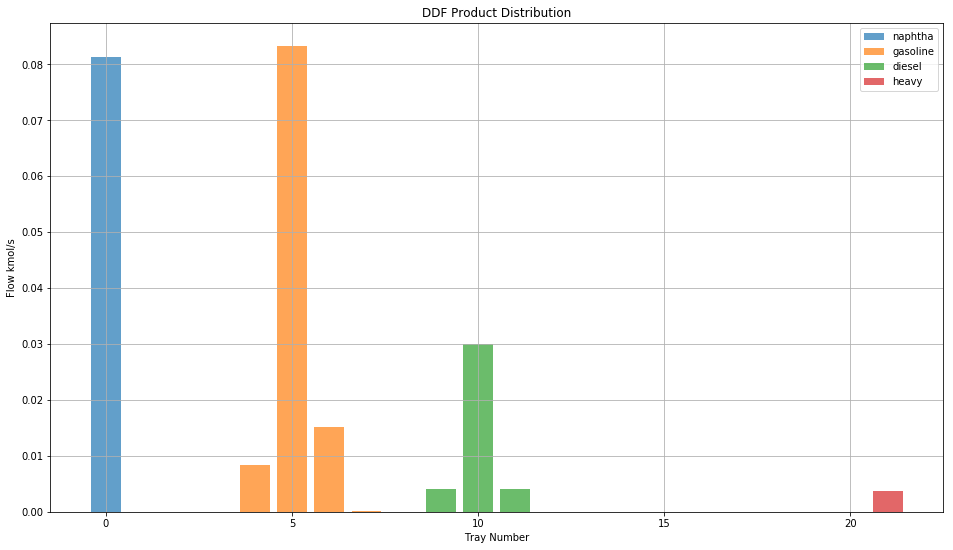

In [32]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)

naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,naphtha_flow,alpha=0.7)
ax.bar(tray_pos,gasoline_flow,alpha=0.7)
ax.bar(tray_pos,diesel_flow,alpha=0.7)
ax.bar(tray_pos,heavy_flow,alpha=0.7)

ax.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('DDF Product Distribution')
ax.set_ylabel('Flow kmol/s')
ax.set_xlabel('Tray Number')

ax.grid()
plt.show()

In [33]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(20)

In [34]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
    

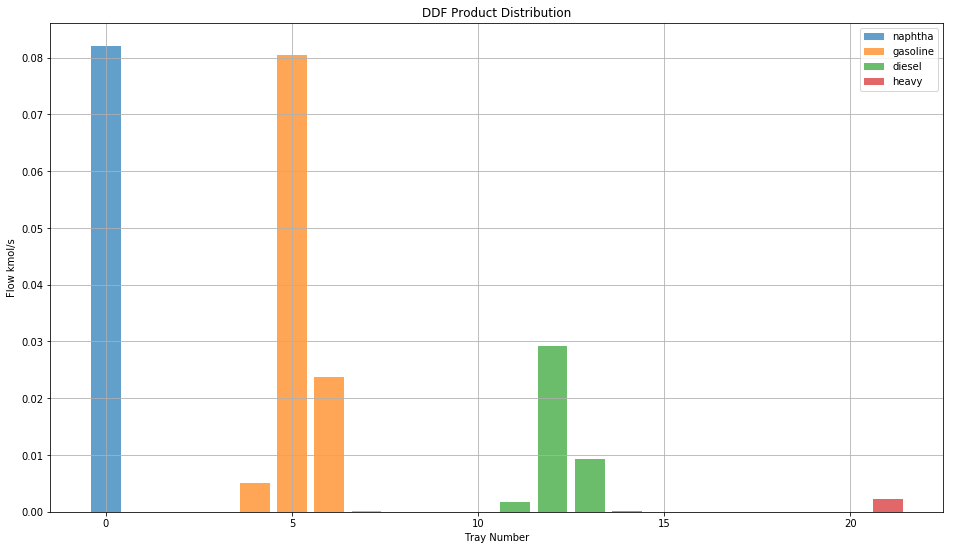

In [35]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)

naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,naphtha_flow,alpha=0.7)
ax.bar(tray_pos,gasoline_flow,alpha=0.7)
ax.bar(tray_pos,diesel_flow,alpha=0.7)
ax.bar(tray_pos,heavy_flow,alpha=0.7)

ax.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('DDF Product Distribution')
ax.set_ylabel('Flow kmol/s')
ax.set_xlabel('Tray Number')

ax.grid()
plt.show()

In [36]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

# plot_distribution(model,pdf,'Optimized Diesel Location')


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 87.74%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -154.                                        2.0987          0.8402  0.0820       2.3344

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     128.5  0.000       0.000  0.000  0.000  0.000       5.3555  0.0000  1.0040  0.0000       20.000
NON--[2]     142.5  0.000       0.000  0.000  0.000  0.000       5.5193  0.0000  0.9182  0.0000       20.000
NON--[3]     154.4  0.000       0.000  0.000  0.000  0.000       5.4335  0.0000  0.8276  0.0000       20.000
NON--[4]     166.8  0.000       0.000  0.000  0.00

# Open up feed allocation

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [37]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)

In [38]:
model.total_feed_con = pe.ConstraintList()

In [39]:
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [40]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [41]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2130670e-01 3.05e-01 1.79e+06  -6.0 5.29e+02  -9.2 6.42e-01 1.61e-01h  1
  66 -1.2180963e-01 6.55e-01 2.87e+05  -6.0 2.25e+02  -8.8 8.65e-01 8.40e-01h  1
  67 -1.2211506e-01 1.08e+00 2.10e+05  -6.0 6.33e+02  -9.2 4.74e-01 2.68e-01h  1
  68 -1.2234098e-01 1.46e+00 1.99e+05  -6.0 3.13e+03  -9.7 4.48e-02 5.01e-02h  1
  69 -1.2234483e-01 1.46e+00 1.99e+05  -6.0 7.61e+02  -9.3 3.57e-03 3.32e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2282994e-01 4.14e+00 1.78e+05  -6.0 3.44e+03  -9.8 8.34e-02 1.06e-01f  1
  71 -1.2284358e-01 2.54e+00 1.09e+05  -6.0 2.34e+01  -6.6 2.38e-01 3.85e-01h  1
  72 -1.2284492e-01 2.43e+00 1.04e+05  -6.0 8.05e+00  -7.1 1.00e+00 4.63e-02h  1
  73 -1.2281055e-01 1.26e-02 1.94e+01  -6.0 1.60e+01  -7.6 3.76e-01 1.00e+00h  1
  74 -1.2290502e-01 4.67e-02 1.42e+00  -6.0 4.63e+01  -8.1 1.00e+00 1.00e+00h  1
  75 -1.2312170e-01 3.91e-01 1.41e+00  -6.0 1.34e+02  -8.6 1.00e+00 1.00e+00h  1
  76 -1.2357036e-01 2.00e+00

 157 -1.2847610e-01 6.11e-02 9.99e+01  -9.0 7.71e+01    -  5.13e-01 6.90e-01h  1
 158 -1.2849754e-01 5.52e-02 5.03e+02  -9.0 1.09e+02    -  4.91e-01 2.47e-01h  1
 159 -1.2858024e-01 2.71e-01 1.33e+03  -9.0 1.22e+02    -  6.77e-03 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.2859127e-01 2.58e-01 1.84e+03  -9.0 2.79e+02    -  4.08e-03 5.63e-02h  1
 161 -1.2859089e-01 2.58e-01 1.29e+04  -9.0 1.56e+04    -  2.38e-05 1.55e-04h  7
 162 -1.2861689e-01 2.22e-01 9.22e+03  -9.0 1.87e+02    -  3.82e-01 2.91e-01h  1
 163 -1.2867120e-01 5.14e-01 5.93e+02  -9.0 1.81e+02    -  2.72e-01 1.00e+00h  1
 164 -1.2867750e-01 4.48e-01 5.13e+02  -9.0 1.06e+02    -  7.16e-01 1.36e-01h  1
 165 -1.2872524e-01 1.71e-01 4.57e-03  -9.0 1.04e+02    -  1.00e+00 1.00e+00h  1
 166 -1.2875193e-01 1.13e-01 2.44e+00  -9.0 5.99e+01    -  4.85e-01 3.89e-01h  1
 167 -1.2882588e-01 3.22e-02 2.51e-03  -9.0 4.21e+01    -  1.00e+00 1.00e+00h  1
 168 -1.2886048e-01 2.52e-02

In [ ]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

# plot_distribution(model,pdf,'Optimized Feed Amount and Location')

In [ ]:
plot_distribution(model)

In [ ]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)

naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,naphtha_flow,alpha=0.7)
ax.bar(tray_pos,gasoline_flow,alpha=0.7)
ax.bar(tray_pos,diesel_flow,alpha=0.7)
ax.bar(tray_pos,heavy_flow,alpha=0.7)

ax.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('DDF Product Distribution')
ax.set_ylabel('Flow kmol/s')
ax.set_xlabel('Tray Number')

ax.grid()
plt.show()

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3
        
* Catalyst
    * cat: 0 - 10000

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75 / 0.8
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * sum feed = 10 kmol/s
    
* Total catalyst
    * sum cat = 30000 kg
    
**Objective:**
* Max gasoline production

In [ ]:
for j in model.reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [ ]:
model.total_cat_con = pe.ConstraintList()

In [ ]:
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [ ]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

In [ ]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

In [ ]:
# pdf.close()

In [ ]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [ ]:
# for j in model.TRAY_reactive:
#     print('stage',j,'\n')
#     print('Total Flow\t{}'.format(model.reactive[j].F.value + sum(model.reactive[j].r_total_comp[i].value for i in m.COMP_TOTAL)))
#     for i in m.COMP_TOTAL:
#         if i in m.COMP_FEED:
#             print('{}\t\t{}'.format(i,model.reactive[j].F.value*model.reactive[j].z[i].value + model.reactive[j].r_total_comp[i].value))
#         else:
#             print('{}\t\t{}'.format(i,model.reactive[j].r_total_comp[i].value))